<a href="https://colab.research.google.com/github/JuanDMaldonado122/Matematicas-Aplicadas-1/blob/main/Prediccion_generaci%C3%B3n_de_energ%C3%ADa_ICESI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving datos_solares.csv to datos_solares (2).csv


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Pérdida final (entrenamiento): 0.1465
Pérdida final (validación): 0.1802


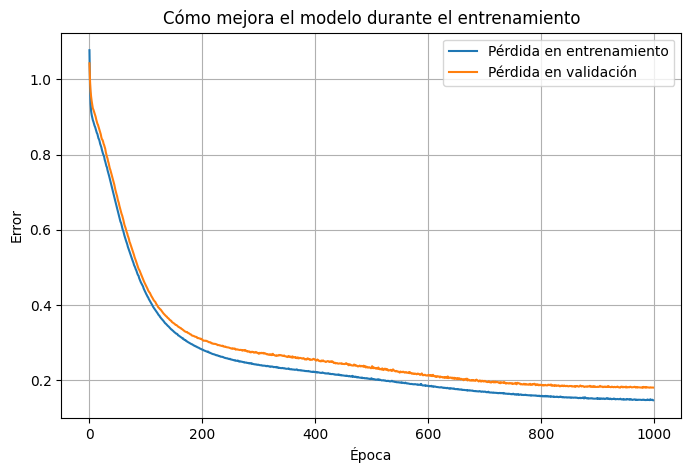

Ingrese el día (1-31): 3
Ingrese el mes (1-12): 4
Ingrese el año (por ejemplo, 2026): 2026


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Energía predicha para 3/4/2026: 9.57 kWh


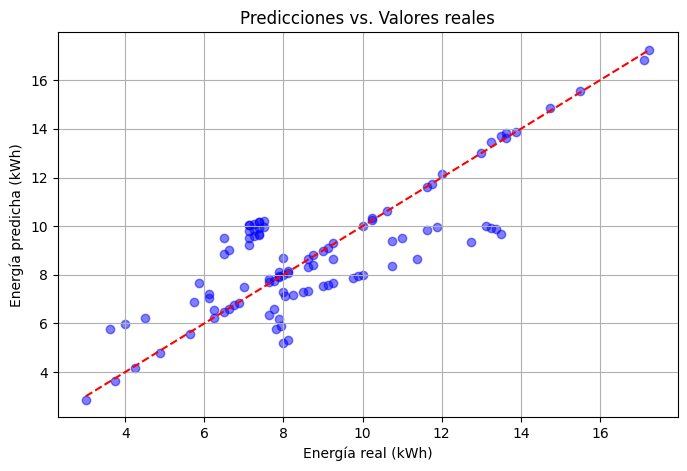

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import files
from datetime import datetime

# Paso 1: Subir y cargar el archivo CSV
archivo_subido = files.upload()  # Sube 'datos_solares.csv'
datos = pd.read_csv('datos_solares.csv')

# Convertir a datos diarios (sumar vatios y convertir a kWh)
datos['Fecha'] = pd.to_datetime(datos['Tiempo']).dt.date
datos_diarios = datos.groupby('Fecha')['Producción (W)'].sum().reset_index()
datos_diarios['Producción (kWh)'] = datos_diarios['Producción (W)'] / 1000 / 4
datos = datos_diarios.rename(columns={'Fecha': 'Fecha'})

# Paso 2: Crear características a partir de la fecha
datos['Fecha'] = pd.to_datetime(datos['Fecha'])
datos['Día_del_Año'] = datos['Fecha'].dt.dayofyear  # Captura la estacionalidad

# Definir entradas (X) y salida (y)
características = ['Día_del_Año']
objetivo = 'Producción (kWh)'
X = datos[características]
y = datos[objetivo]

# Escalar datos para mejorar el entrenamiento
escalador_X = StandardScaler()
escalador_y = StandardScaler()
X_escalado = escalador_X.fit_transform(X)
y_escalado = escalador_y.fit_transform(y.values.reshape(-1, 1))

# Dividir en datos de entrenamiento y prueba
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X_escalado, y_escalado, test_size=0.2, random_state=42)

# Paso 3: Crear una red neuronal simple
modelo = Sequential([
    Dense(16, activation='relu', input_shape=(1,)),  # Capa con 16 neuronas
    Dense(1)  # Capa de salida para predecir energía
])
modelo.compile(optimizer=SGD(learning_rate=0.01), loss='mean_squared_error')

# Entrenar el modelo sin mostrar detalles
historia = modelo.fit(X_entrenamiento, y_entrenamiento, epochs=1000, validation_split=0.2, verbose=0)

# Mostrar pérdida final
pérdida_final = historia.history['loss'][-1]
pérdida_validación = historia.history['val_loss'][-1]
print(f'Pérdida final (entrenamiento): {pérdida_final:.4f}')
print(f'Pérdida final (validación): {pérdida_validación:.4f}')

# Paso 4: Graficar la pérdida del modelo
plt.figure(figsize=(8, 5))
plt.plot(historia.history['loss'], label='Pérdida en entrenamiento')
plt.plot(historia.history['val_loss'], label='Pérdida en validación')
plt.title('Cómo mejora el modelo durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

# Paso 5: Predecir para una fecha ingresada por el usuario
def predecir_energía(día_del_año):
    entrada = np.array([[día_del_año]])
    entrada_escalada = escalador_X.transform(entrada)
    predicción_escalada = modelo.predict(entrada_escalada, verbose=0)
    predicción = escalador_y.inverse_transform(predicción_escalada)
    return predicción[0][0]

# Solicitar fecha al usuario
día = int(input('Ingrese el día (1-31): '))
mes = int(input('Ingrese el mes (1-12): '))
año = int(input('Ingrese el año (por ejemplo, 2026): '))
día_del_año = datetime(año, mes, día).timetuple().tm_yday

# Mostrar predicción
energía_predicha = predecir_energía(día_del_año)
print(f'Energía predicha para {día}/{mes}/{año}: {energía_predicha:.2f} kWh')

# Paso 6: Graficar predicciones vs. valores reales
y_pred_escalada = modelo.predict(X_prueba, verbose=0)
y_pred = escalador_y.inverse_transform(y_pred_escalada)
y_prueba_real = escalador_y.inverse_transform(y_prueba)

plt.figure(figsize=(8, 5))
plt.scatter(y_prueba_real, y_pred, color='blue', alpha=0.5)
plt.plot([y_prueba_real.min(), y_prueba_real.max()], [y_prueba_real.min(), y_prueba_real.max()], 'r--')
plt.title('Predicciones vs. Valores reales')
plt.xlabel('Energía real (kWh)')
plt.ylabel('Energía predicha (kWh)')
plt.grid(True)
plt.show()

El código desarrollado predice la producción de energía solar diaria de la Universidad Icesi utilizando una red neuronal simple implementada en Google Colab, basada en datos históricos almacenados en un archivo CSV con columnas como Plant Name, Tiempo y Producción (W). El proceso comienza cargando y procesando los datos, convirtiendo las fechas en el "día del año" para capturar patrones estacionales, y escalando los valores para facilitar el aprendizaje. Luego, se construye una red neuronal con dos capas (una con 16 neuronas y una de salida) que aprende a relacionar el día del año con la producción en kWh. El modelo se entrena durante 1000 épocas utilizando el descenso de gradiente estocástico (SGD), un algoritmo clave que ajusta los pesos de la red para minimizar el error cuadrático medio. En cada época, SGD calcula la pendiente del error y actualiza los pesos con pequeños pasos (tasa de aprendizaje de 0.01), como bajar una colina para encontrar el punto de menor error, lo que se refleja en la disminución de la pérdida mostrada en una gráfica. El código genera solo salidas esenciales: la pérdida final, una gráfica de cómo mejora el modelo, y una comparación de predicciones versus valores reales. Además, permite al usuario ingresar una fecha futura para predecir la energía, mostrando resultados claros como "10.50 kWh". El uso del descenso de gradiente es fundamental, ya que es el mecanismo que "enseña" al modelo a mejorar sus predicciones ajustando los pesos de manera iterativa, haciendo que el modelo sea efectivo y fácil de explicar.